## Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import metrics, model_selection
import xgboost as xgb
from xgboost import XGBRegressor

### Util functions

In [103]:
def plot_corr(df):
    """
    Plots the correlation matrix for a pandas DataFrame as a heatmap with annotations.
    
    Args:
    - df: pandas DataFrame
    
    Returns:
    - None
    """
    # drop columns with non-numeric data and uid column
    numeric_cols = df.select_dtypes(include=['float', 'int']).columns
    df = df[numeric_cols].drop(['uid'], axis=1, errors='ignore')
    
    # compute correlation matrix
    corr = df.corr()
    
    # create a mask to hide redundant correlations
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # set up the figure and colormap
    plt.figure(figsize=(12, 10))
    cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, center="light", as_cmap=True)
    
    # plot the heatmap
    sns.heatmap(corr, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap=cmap)
    
    # show the plot
    plt.show()
    
def drop_highly_correlated_cols(df, threshold=0.8):
    """
    Given a pandas DataFrame, computes the correlation matrix and drops one of the columns from
    each highly correlated pair (correlation coefficient > threshold).
    
    Args:
    - df: pandas DataFrame
    - threshold: correlation coefficient threshold for identifying highly correlated columns (default=0.8)
    
    Returns:
    - pandas DataFrame with one column from each highly correlated pair removed
    """
    # compute the correlation matrix
    corr_matrix = df.corr().abs()

    # create a mask to identify highly correlated pairs
    mask = corr_matrix.mask(np.tril(np.ones_like(corr_matrix, dtype=bool)))

    # identify the highly correlated columns
    cols_to_drop = []
    for c in mask.columns:
        if any(mask[c] > threshold):
            cols_to_drop.append(mask[c][mask[c] > threshold].index[0])

    # drop one of the columns from each highly correlated pair
    df = df.drop(columns=cols_to_drop)

    return df

## Load and prepare data

In [3]:
orders = pd.read_csv('orders.csv' )
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [4]:
print("orders: \n", orders.head())
print("order_products_train: \n", order_products_train.head())
print("order_products_prior: \n", order_products_prior.head())
print("products: \n", products.head())
print("aisles: \n", aisles.head())
print("departments: \n", departments.head())

orders: 
    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
order_products_train: 
    order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
order_produ

### Features handling and Exploratory Data Analysis

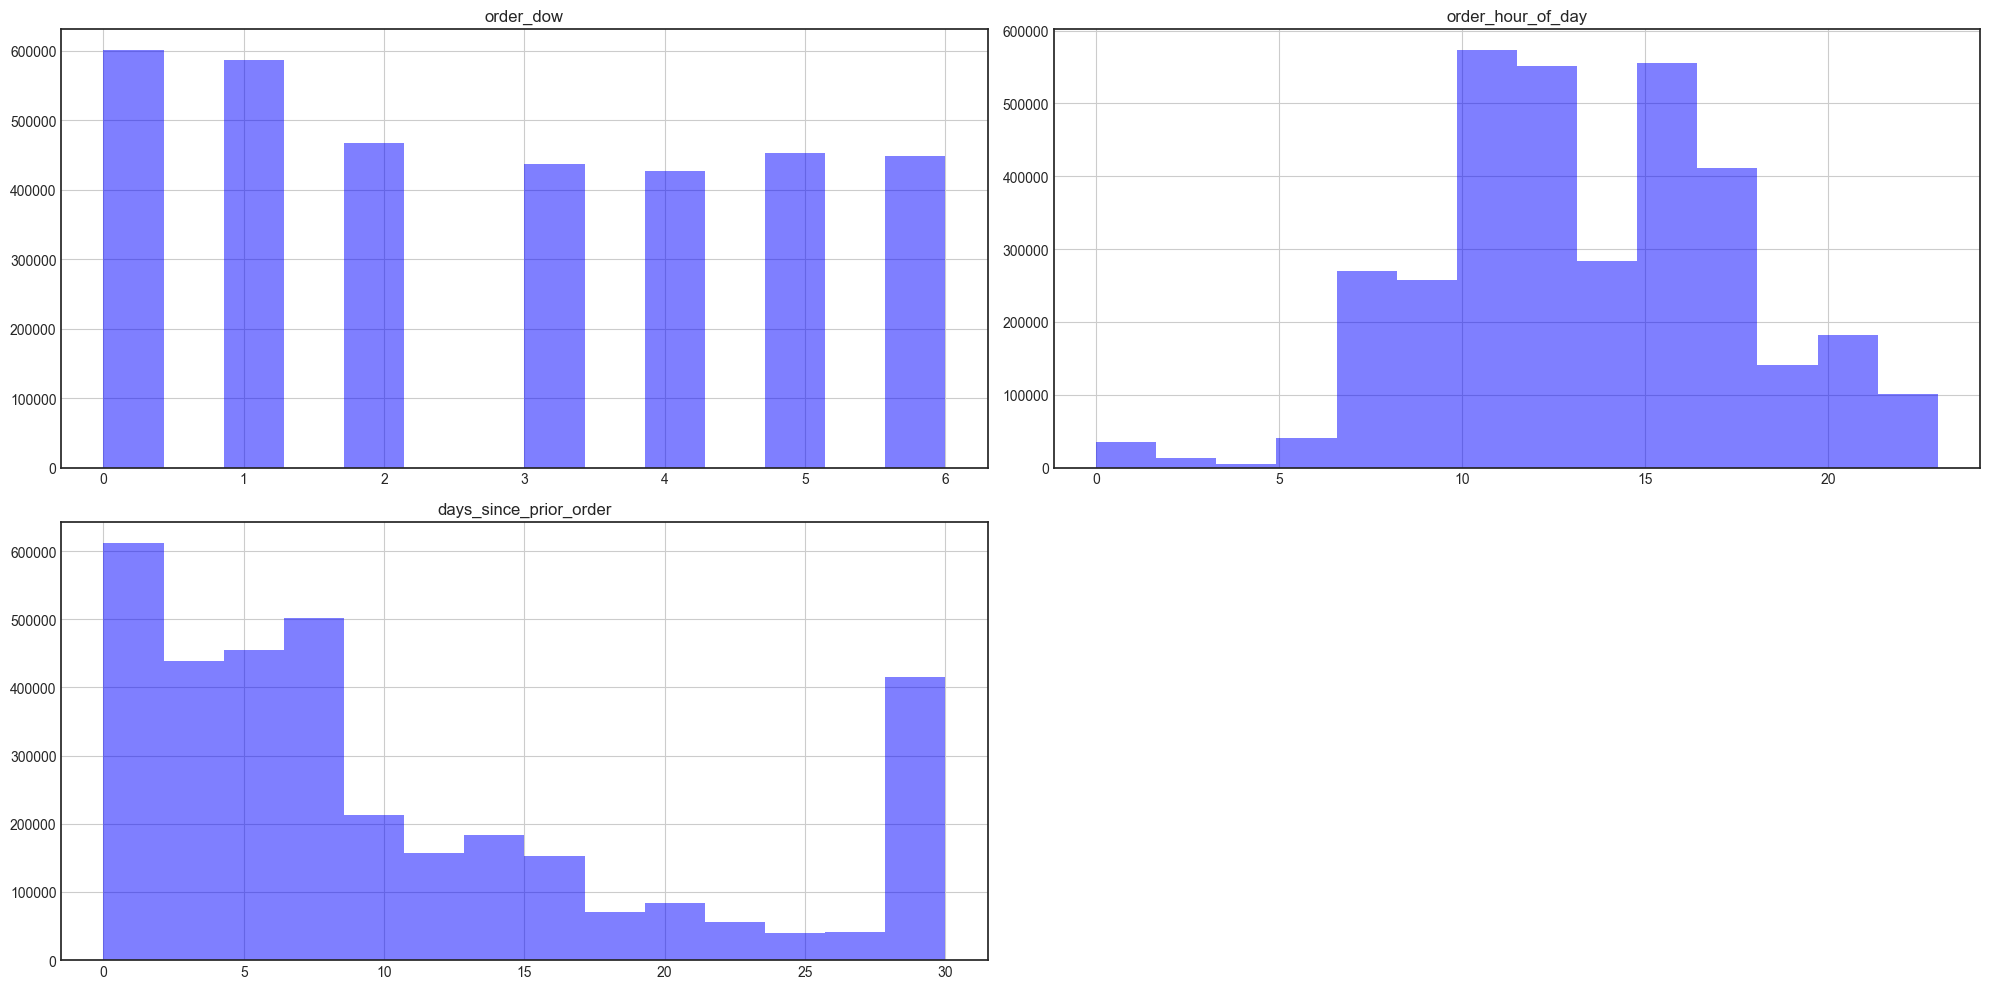

In [85]:
plt.style.use('seaborn-white')
orders.iloc[:, 4:].hist(bins = 14, figsize=(20, 10), alpha = 0.5, histtype='stepfilled', color='blue',
                edgecolor='none')
plt.tight_layout()

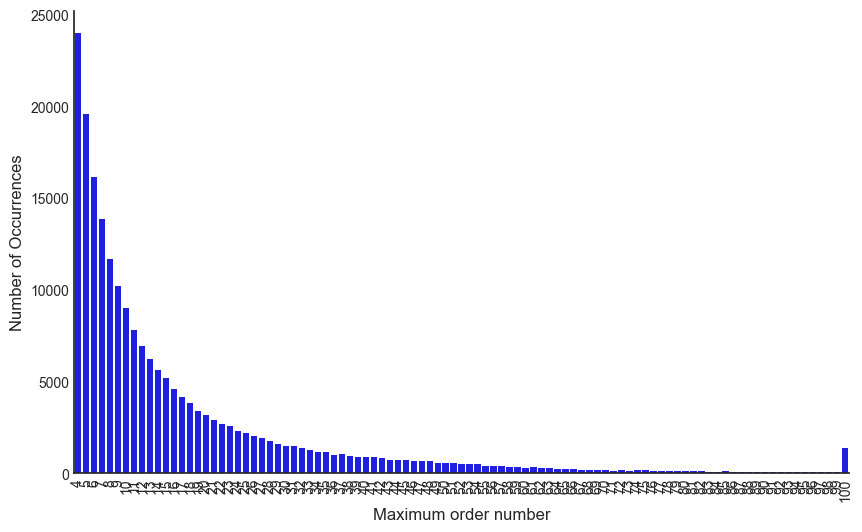

In [86]:
ax = sns.countplot(x=orders.groupby('user_id')['order_number'].max(),
                   color= 'blue')
ax.set_xlabel('Maximum order number', fontsize=12)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.tick_params(axis='x', labelrotation=90)
sns.despine()

In [5]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [6]:
# apply a lambda function to each column to get the length of unique occurrences
unique_counts = orders.apply(lambda x: len(x.unique()))

# print the results
print(unique_counts)

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         32
dtype: int64


In [7]:
# Finding missing values
orders.isnull().sum().sort_values(ascending=False)

days_since_prior_order    206209
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
dtype: int64

In [8]:
orders['days_since_prior_order'].fillna(0, inplace=True)

In [9]:
# Using only 'prior' data
orders_prior_filter = orders[orders['eval_set'] == 'prior']

In [10]:
# creating user statistics
user_stats = orders_prior_filter
user_stats['days_since_prior_order'].dropna()
# Group orders by user_id and calculate the variables based on different user_id
user_stats = user_stats.groupby('user_id').agg(
    total_orders=('order_number', max),
    total_duration=('days_since_prior_order', sum),
    mean_days=('days_since_prior_order', 'mean'),
    max_days=('days_since_prior_order', max),
    min_days=('days_since_prior_order', min)    
)

user_stats = user_stats.reset_index()
user_stats.head()

,user_id,total_orders,total_duration,mean_days,max_days,min_days
0,1,10,176.0,17.600000,30.0,0.0
1,2,14,198.0,14.142857,30.0,0.0
2,3,12,133.0,11.083333,21.0,0.0
3,4,5,55.0,11.000000,21.0,0.0
4,5,4,40.0,10.000000,19.0,0.0


In [11]:
orders_prior_filter = pd.merge(orders_prior_filter, user_stats, on = 'user_id')

# collating previous time points as t1 to t5
shift_periods = [1, 2, 3, 4, 5]
col_names = [f"t{period}" for period in shift_periods]

# iterate over the shift periods and column names, and assign the shifted values to new columns
for shift_period, col_name in zip(shift_periods, col_names):
    orders_prior_filter[col_name] = orders_prior_filter.groupby(['user_id'])['days_since_prior_order'].shift(shift_period).fillna(0)
    
orders_prior_filter.head()    

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders,total_duration,mean_days,max_days,min_days,t1,t2,t3,t4,t5
0,2539329,1,prior,1,2,8,0.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2398795,1,prior,2,3,7,15.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0
2,473747,1,prior,3,3,12,21.0,10,176.0,17.6,30.0,0.0,15.0,0.0,0.0,0.0,0.0
3,2254736,1,prior,4,4,7,29.0,10,176.0,17.6,30.0,0.0,21.0,15.0,0.0,0.0,0.0
4,431534,1,prior,5,4,15,28.0,10,176.0,17.6,30.0,0.0,29.0,21.0,15.0,0.0,0.0


In [134]:
orders_products_prior_merge = pd.merge(orders_prior_filter, order_products_prior, on = 'order_id')

# Group order_products_prior_merge by order_id to calculate basket size
grouped_orders_products = orders_products_prior_merge.groupby(['order_id']).agg(
    basket_size=('product_id', 'count')
).reset_index()

# Merge basket size information back to the order_products_prior_merge dataframe
orders_products_basket_size = pd.merge(orders_products_prior_merge, grouped_orders_products, on='order_id')

orders_products_basket_size.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders,total_duration,mean_days,max_days,min_days,t1,t2,t3,t4,t5,product_id,add_to_cart_order,reordered,basket_size
0,2539329,1,prior,1,2,8,0.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,196,1,0,5
1,2539329,1,prior,1,2,8,0.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,14084,2,0,5
2,2539329,1,prior,1,2,8,0.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,12427,3,0,5
3,2539329,1,prior,1,2,8,0.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,26088,4,0,5
4,2539329,1,prior,1,2,8,0.0,10,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,26405,5,0,5


In [200]:
# Add columns to indicate whether a product was reordered and whether it was ordered after the first order
orders_products_basket_size['product_was_reordered'] = orders_products_basket_size['reordered'].apply(lambda x: x == 1)
orders_products_basket_size['product_ordered_after_first'] = orders_products_basket_size['order_number'].apply(lambda x: x > 1)
orders_products_basket_size['days_since_prior_order_per_product'] = abs(orders_products_basket_size['days_since_prior_order'] - orders_products_basket_size.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(1))

# Group orders_products by user_id and calculate various metrics
prod_stats_user = orders_products_basket_size.groupby('user_id').agg(
    total_products_ordered=('user_id', 'count'),
    total_products_reordered=('product_was_reordered', 'sum'),
    total_products_ordered_after_first=('product_ordered_after_first', 'sum'),
    total_distinct_products_ordered=('product_id', 'nunique')
).reset_index()
# Calculate the ratio of reordered products to products ordered after the first order for each user
prod_stats_user['reorder_ratio'] =prod_stats_user.apply(lambda row: row['total_products_reordered'] / row['total_products_ordered_after_first'], axis=1)
prod_stats_user.drop(columns=['total_products_reordered','total_products_ordered_after_first'], inplace=True)

# Group orders_products_basket_size by product_id to calculate product features
prod_features = orders_products_basket_size.groupby(['product_id']).agg(
    prod_freq = ('order_id', 'count'),
    avg_days_since_prior_order=('days_since_prior_order', 'mean')
).reset_index()

final_df = pd.merge(orders_products_basket_size, prod_stats_user, on ='user_id')
final_df = pd.merge(final_df, prod_features, on ='product_id')
final_df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'total_orders',
       'total_duration', 'mean_days', 'max_days', 'min_days', 't1', 't2', 't3',
       't4', 't5', 'product_id', 'add_to_cart_order', 'reordered',
       'basket_size', 'product_was_reordered', 'product_ordered_after_first',
       'days_since_prior_order_per_product', 'total_products_ordered',
       'total_distinct_products_ordered', 'reorder_ratio', 'prod_freq',
       'avg_days_since_prior_order'],
      dtype='object')

In [201]:
final_df['average_basket_size'] = final_df['total_products_ordered'] / final_df['total_orders']
rfm_analysis = final_df
final_df.drop(columns=['order_id', 'eval_set', 'order_number', 'order_dow','order_hour_of_day', 'add_to_cart_order', 
       'basket_size', 'product_was_reordered', 'product_ordered_after_first','days_since_prior_order_per_product',
       'total_distinct_products_ordered','total_orders'], inplace=True)


final_df.rename(columns = {'days_since_prior_order': 't0'}, inplace = True)

In [137]:
final_df.head()

,user_id,t0,total_duration,mean_days,max_days,min_days,t1,t2,t3,t4,t5,product_id,reordered,total_products_ordered,reorder_ratio,prod_freq,avg_days_since_prior_order,average_basket_size
0,1,0.0,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,196,0,59,0.759259,35791,11.195803,5.9
1,1,15.0,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9
2,1,21.0,176.0,17.6,30.0,0.0,15.0,0.0,0.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9
3,1,29.0,176.0,17.6,30.0,0.0,21.0,15.0,0.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9
4,1,28.0,176.0,17.6,30.0,0.0,29.0,21.0,15.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9


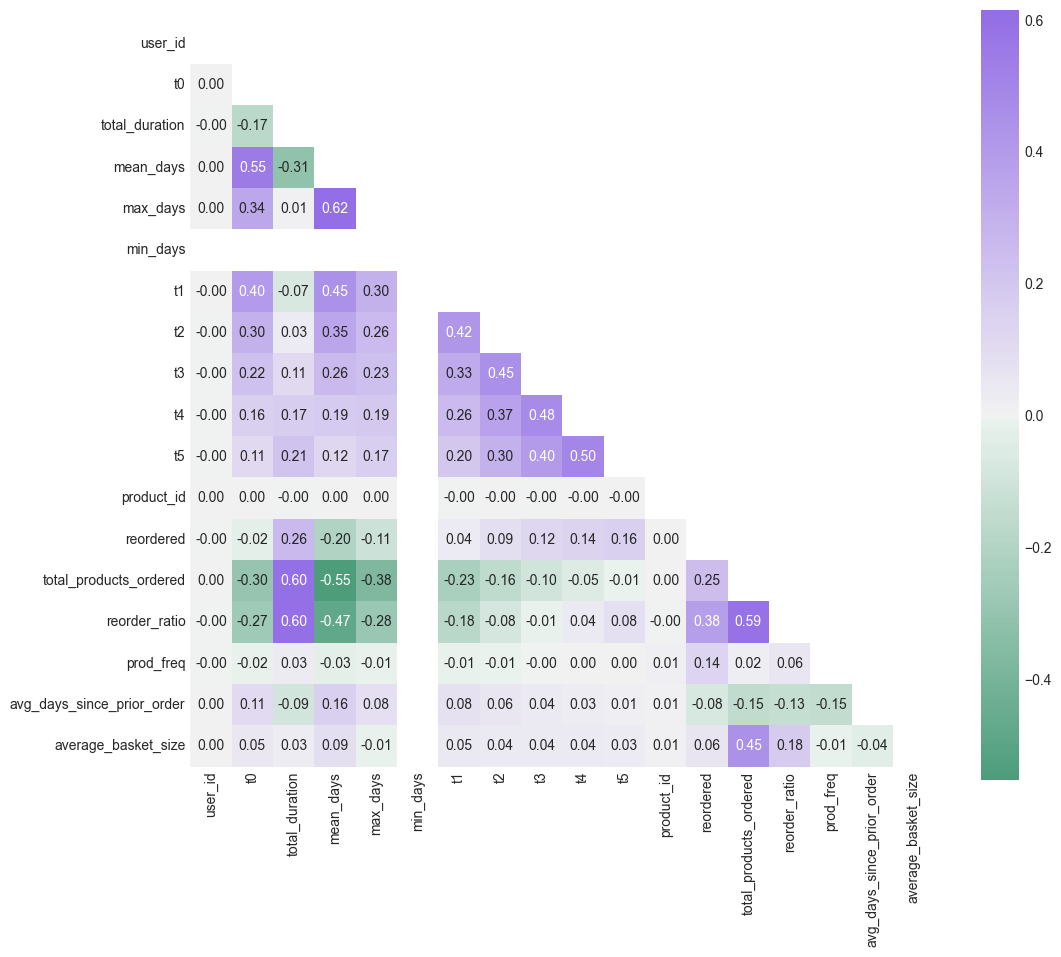

In [138]:
plot_corr(final_df)

In [139]:
get_highly_correlated_pairs(final_df, threshold=0.6)

[('max_days', 'mean_days'),
 ('mean_days', 'max_days'),
 ('reorder_ratio', 'total_duration'),
 ('total_duration', 'reorder_ratio')]

In [141]:
# we exclude prior orders and keep only train and test orders
train_test = orders[orders['eval_set'] != 'prior']
train_test['next_purchase_day'] = train_test['days_since_prior_order']
train_test = train_test[['user_id','eval_set','next_purchase_day']]

# We combine users and us tables and store the results into the users table
train_test_df = pd.merge(final_df, train_test, on='user_id', how='inner') 
train_test_df = train_test_df[['user_id', 'product_id', 'mean_days', 'min_days', 
       't0', 't1', 't2', 't3', 't4', 't5', 'reordered','avg_days_since_prior_order', 'total_products_ordered', 'reorder_ratio',
       'average_basket_size', 'eval_set', 'next_purchase_day']]
train_test_df.head()

,user_id,product_id,mean_days,min_days,t0,t1,t2,t3,t4,t5,reordered,avg_days_since_prior_order,total_products_ordered,reorder_ratio,average_basket_size,eval_set,next_purchase_day
0,1,196,17.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11.195803,59,0.759259,5.9,train,14.0
1,1,196,17.6,0.0,15.0,0.0,0.0,0.0,0.0,0.0,1,11.195803,59,0.759259,5.9,train,14.0
2,1,196,17.6,0.0,21.0,15.0,0.0,0.0,0.0,0.0,1,11.195803,59,0.759259,5.9,train,14.0
3,1,196,17.6,0.0,29.0,21.0,15.0,0.0,0.0,0.0,1,11.195803,59,0.759259,5.9,train,14.0
4,1,196,17.6,0.0,28.0,29.0,21.0,15.0,0.0,0.0,1,11.195803,59,0.759259,5.9,train,14.0


In [142]:
train_test_df.isnull().sum().sort_values(ascending=False)

user_id                       0
t5                            0
eval_set                      0
average_basket_size           0
reorder_ratio                 0
total_products_ordered        0
avg_days_since_prior_order    0
reordered                     0
t4                            0
product_id                    0
t3                            0
t2                            0
t1                            0
t0                            0
min_days                      0
mean_days                     0
next_purchase_day             0
dtype: int64

In [143]:
train_test_df['t0'].fillna(0, inplace=True)
train_test_df['avg_days_since_prior_order'].fillna(0, inplace=True)

In [144]:
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   user_id                     int64  
 1   product_id                  int64  
 2   mean_days                   float64
 3   min_days                    float64
 4   t0                          float64
 5   t1                          float64
 6   t2                          float64
 7   t3                          float64
 8   t4                          float64
 9   t5                          float64
 10  reordered                   int64  
 11  avg_days_since_prior_order  float64
 12  total_products_ordered      int64  
 13  reorder_ratio               float64
 14  average_basket_size         float64
 15  eval_set                    object 
 16  next_purchase_day           float64
dtypes: float64(12), int64(4), object(1)
memory usage: 4.3+ GB


In [145]:
train_test_df.columns

Index(['user_id', 'product_id', 'mean_days', 'min_days', 't0', 't1', 't2',
       't3', 't4', 't5', 'reordered', 'avg_days_since_prior_order',
       'total_products_ordered', 'reorder_ratio', 'average_basket_size',
       'eval_set', 'next_purchase_day'],
      dtype='object')

In [191]:
# Splitting data to train and test
X_train = train_test_df[train_test_df['eval_set'] == 'train']
X_train = X_train.drop(['eval_set','next_purchase_day'], axis=1)
X_test = train_test_df[train_test_df['eval_set'] == 'test']
y_test_actual = X_test['next_purchase_day']
X_test = X_test.drop(['eval_set','next_purchase_day'], axis=1)

In [192]:
X_train.head()

,user_id,product_id,mean_days,min_days,t0,t1,t2,t3,t4,t5,reordered,avg_days_since_prior_order,total_products_ordered,reorder_ratio,average_basket_size
0,1,196,17.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11.195803,59,0.759259,5.9
1,1,196,17.6,0.0,15.0,0.0,0.0,0.0,0.0,0.0,1,11.195803,59,0.759259,5.9
2,1,196,17.6,0.0,21.0,15.0,0.0,0.0,0.0,0.0,1,11.195803,59,0.759259,5.9
3,1,196,17.6,0.0,29.0,21.0,15.0,0.0,0.0,0.0,1,11.195803,59,0.759259,5.9
4,1,196,17.6,0.0,28.0,29.0,21.0,15.0,0.0,0.0,1,11.195803,59,0.759259,5.9


In [193]:
y_train.head()

0    14.0
1    14.0
2    14.0
3    14.0
4    14.0
Name: next_purchase_day, dtype: float64

In [194]:
X_test.head()

,user_id,product_id,mean_days,min_days,t0,t1,t2,t3,t4,t5,reordered,avg_days_since_prior_order,total_products_ordered,reorder_ratio,average_basket_size
59,15,196,10.318182,0.0,7.0,14.0,14.0,6.0,14.0,21.0,0,11.195803,72,0.867647,3.272727
60,15,196,10.318182,0.0,8.0,7.0,7.0,14.0,14.0,6.0,1,11.195803,72,0.867647,3.272727
61,15,196,10.318182,0.0,7.0,8.0,7.0,7.0,14.0,14.0,1,11.195803,72,0.867647,3.272727
62,15,196,10.318182,0.0,7.0,10.0,3.0,7.0,8.0,7.0,1,11.195803,72,0.867647,3.272727
63,15,196,10.318182,0.0,14.0,7.0,10.0,3.0,7.0,8.0,1,11.195803,72,0.867647,3.272727


### Model Fitting

In [198]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, y_train)  # perform linear regression
y_pred = linear_regressor.predict(X_test)  # make predictions
print('Mean Absolute error Test set:', mean_absolute_error(y_test_actual,y_pred))
print('R2 Test set:', r2_score(y_test_actual,y_pred))
print('RMSE Test set:', mean_squared_error(y_test_actual,y_pred))

y_predict_train = linear_regressor.predict(X_train)
print('Mean Absolute error train set:', mean_absolute_error(y_train,y_predict_train))
print('R2 train set:', r2_score(y_train,y_predict_train))
print('RMSE train set:', mean_squared_error(y_train,y_predict_train))

Mean Absolute error Test set: 6.504270490464488
R2 Test set: 0.30612617777341633
RMSE Test set: 67.83047779825475
Mean Absolute error train set: 6.493026635847562
R2 train set: 0.310242729501646
RMSE train set: 67.44265171828161


In [196]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_predict_xgb = model.predict(X_test)
print('Mean Absolute error Test set:', mean_absolute_error(y_test_actual,y_predict_xgb))
print('R2 Test set:', r2_score(y_test_actual,y_predict_xgb))
print('RMSE Test set:', mean_squared_error(y_test_actual,y_predict_xgb))

Mean Absolute error Test set: 6.403682465004655
R2 Test set: 0.3166236883118779
RMSE Test set: 66.80428091244177


Best estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

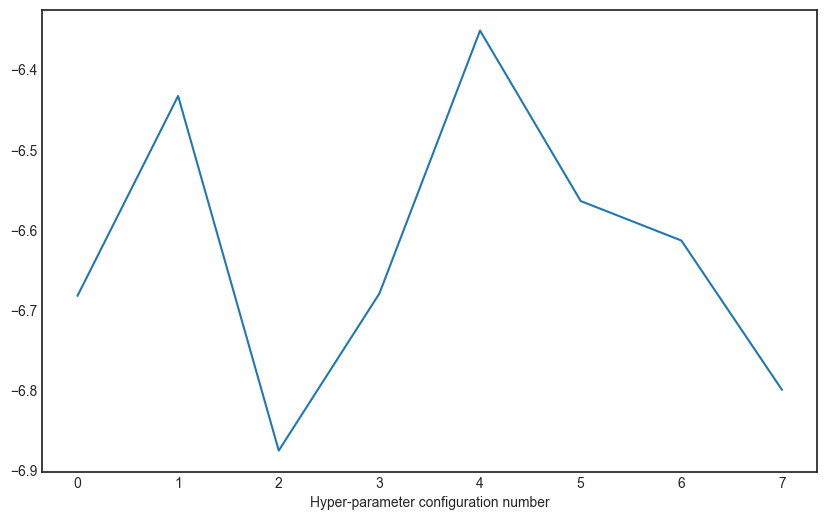

In [231]:
# Hyper parameter training
# specify parameter range
n_estimators = [10, 100]
max_depth = [10, 15]
learning_rate = [0.1, 0.2]

hyperparameter_grid = {
     'n_estimators': n_estimators,
     'max_depth': max_depth,
     'learning_rate': learning_rate,
 }

# Define a randomized search over hyperparameters
random_search = model_selection.RandomizedSearchCV(estimator=model,
                                                   param_distributions=hyperparameter_grid,
                                                   cv=5,
                                                   n_iter=10,
                                                   scoring='neg_mean_absolute_error',
                                                   n_jobs=4,
                                                   return_train_score=True,
                                                   random_state=42)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best estimator found by the randomized search
best_estimator = random_search.best_estimator_
print("Best estimator:", best_estimator)

# Plot the results of the hyperparameter search
results = pd.DataFrame(random_search.cv_results_)
scores = results['mean_test_score'].values
plt.plot(scores)
plt.xlabel('Hyper-parameter configuration number')
plt.ylabel


In [232]:
# model with best hyperparameters
xgb_best_model = XGBRegressor(learning_rate=0.2, max_depth=10, n_estimators=10)

In [253]:
xgb_best_model.fit(X_train, y_train)
y_predict = xgb_best_model.predict(X_test)
y_predict_train = xgb_best_model.predict(X_train)
print('Mean Absolute error Test set:', mean_absolute_error(y_test_actual,y_predict))
print('R2 Test set:', r2_score(y_test_actual,y_predict))
print('RMSE Test set:', mean_squared_error(y_test_actual,y_predict))

Mean Absolute error Test set: 6.320378540678264
R2 Test set: 0.3001330710193687
RMSE Test set: 68.41634122414177


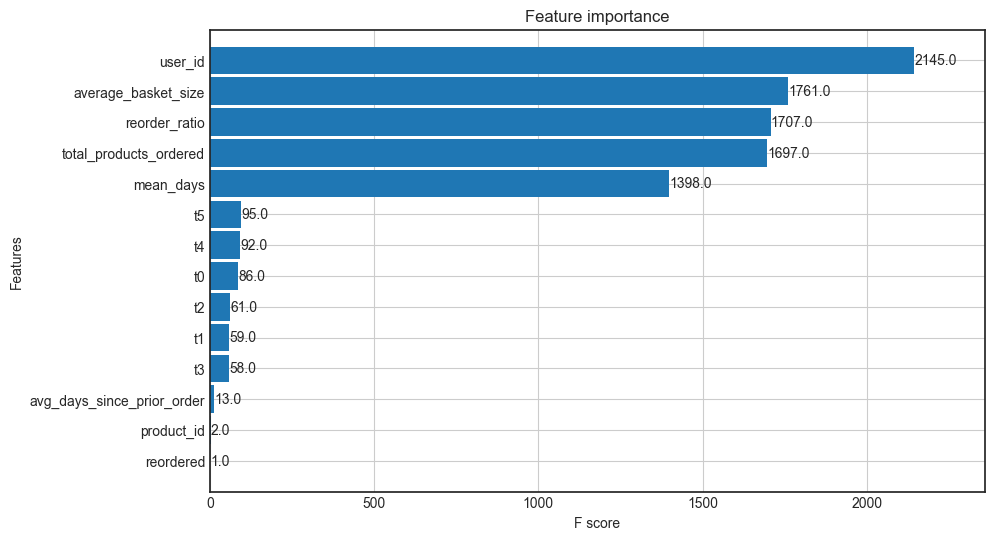

In [237]:
# feature importance
_ = xgb.plot_importance(xgb_best_model, height=0.9)

### User segmentation using RFM analysis

In [210]:
rfm_analysis = final_df
# Group the rows by user ID and count the number of orders for each user
orders_per_user = orders_prior_filter.groupby(by='user_id', as_index=False)['order_id'].count()

# Sort the resulting DataFrame by the count of orders in descending order
orders_per_user_sorted = orders_per_user.sort_values(by='order_id', ascending=False)
orders_per_user_sorted.rename(columns={'order_id': 'total_no_orders'}, inplace=True)

rfm_analysis = pd.merge(rfm_analysis, orders_per_user_sorted, on = 'user_id')


In [211]:
rfm_analysis.head()

,user_id,t0,total_duration,mean_days,max_days,min_days,t1,t2,t3,t4,t5,product_id,reordered,total_products_ordered,reorder_ratio,prod_freq,avg_days_since_prior_order,average_basket_size,total_no_orders
0,1,0.0,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,196,0,59,0.759259,35791,11.195803,5.9,10
1,1,15.0,176.0,17.6,30.0,0.0,0.0,0.0,0.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9,10
2,1,21.0,176.0,17.6,30.0,0.0,15.0,0.0,0.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9,10
3,1,29.0,176.0,17.6,30.0,0.0,21.0,15.0,0.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9,10
4,1,28.0,176.0,17.6,30.0,0.0,29.0,21.0,15.0,0.0,0.0,196,1,59,0.759259,35791,11.195803,5.9,10


In [214]:
rfm_analysis = rfm_analysis[['user_id', 'product_id','t0', 'total_no_orders','average_basket_size']]
rfm_analysis.rename(columns={'t0':'recency', 'total_no_orders': 'frequency', 'average_basket_size':'monetary'}, inplace=True)

In [219]:
rfm_analysis.head()

,user_id,product_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
0,1,196,0.0,10,5.9,1,4,4
1,1,196,15.0,10,5.9,4,4,4
2,1,196,21.0,10,5.9,4,4,4
3,1,196,29.0,10,5.9,4,4,4
4,1,196,28.0,10,5.9,4,4,4


In [218]:
# qcut bins each column into 4 based equal quantiles
rfm_analysis['r_quartile'] = pd.qcut(rfm_analysis['recency'], 4, ['1','2','3','4'])
rfm_analysis['f_quartile'] = pd.qcut(rfm_analysis['frequency'], 4, ['4','3','2','1'])
rfm_analysis['m_quartile'] = pd.qcut(rfm_analysis['monetary'], 4, ['4','3','2','1'])

In [238]:
rfm_analysis['RFM_group'] = rfm_analysis.r_quartile.astype(str)+ rfm_analysis.f_quartile.astype(str) + rfm_analysis.m_quartile.astype(str)
rfm_analysis.head()

,user_id,product_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_group
0,1,196,0.0,10,5.9,1,4,4,144,144
1,1,196,15.0,10,5.9,4,4,4,444,444
2,1,196,21.0,10,5.9,4,4,4,444,444
3,1,196,29.0,10,5.9,4,4,4,444,444
4,1,196,28.0,10,5.9,4,4,4,444,444


In [244]:
# Create RFM score groups
rfm_analysis["RFM_score"] = rfm_analysis[['r_quartile','f_quartile','m_quartile']].sum(axis=1)

# Define group labels
group_labels = {
    "111": "Best Customers",
    "112": "Loyal Customers",
    "121": "Big Spenders",
    "211": "Recent Customers",
    "311": "Promising Customers",
    "113": "Almost Lost",
    "131": "Lost Customers",
    "231": "Lost Promising Customers",
    "444": "Lost Non-promising Customers"
}

# Assign group labels to RFM groups
rfm_analysis["RFM_group_label"] = rfm_analysis["RFM_group"].map(group_labels)

# Print results
print(rfm_analysis.groupby("RFM_group_label")["RFM_score"].count())

RFM_group_label
Almost Lost                     1142783
Best Customers                   570526
Big Spenders                     320761
Lost Customers                   250319
Lost Non-promising Customers     960774
Lost Promising Customers         454805
Loyal Customers                  913518
Promising Customers              288987
Recent Customers                 685408
Name: RFM_score, dtype: int64


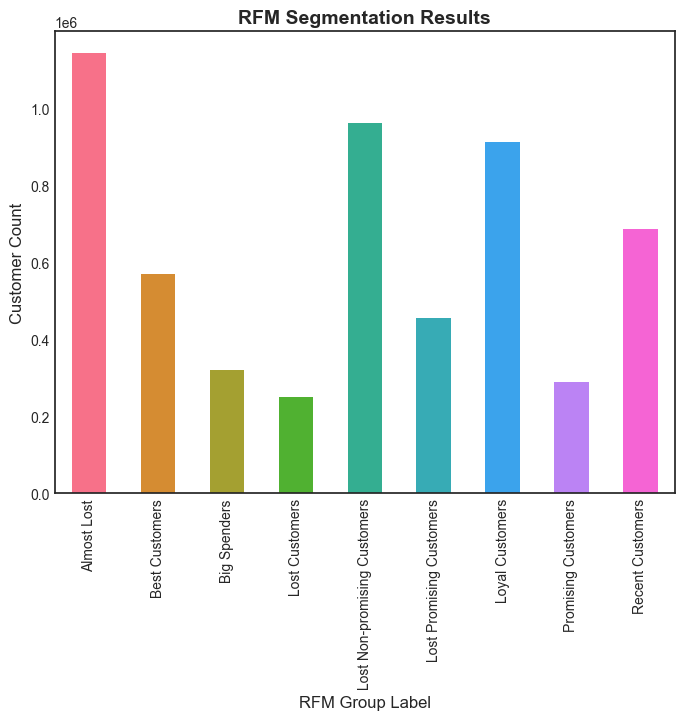

In [248]:
# Plot RFM group counts
rfm_counts = rfm_analysis.groupby("RFM_group_label")["RFM_score"].count()
# Define color palette
colors = sns.color_palette("husl", len(rfm_counts))

# Plot RFM group counts with colors
rfm_counts.plot.bar(figsize=(8, 6), color=colors)

# Set plot title and axis labels
plt.title("RFM Segmentation Results", fontsize=14, fontweight="bold")
plt.xlabel("RFM Group Label", fontsize=12)
plt.ylabel("Customer Count", fontsize=12)

# Show plot
plt.show()